In [1]:
import numpy as np
import car_model
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [6]:
# Run with noise
noise = False

# Define the model
eta = 0.25
m_b = 0.01 # mass of the ball
m_c = 500 # mass of the ball
g = 9.8 # gravity
r = 1 # radius of the pendulum
model = car_model.Model(eta, m_b,m_c,g,r)

# Define T_Horizon and timesteps
tf = 300           # final time for simulation
nsteps = 300             # number of time steps
delta_t = tf/(nsteps)   # how long is each time step?
ts = np.linspace(0,tf,nsteps) # linearly spaced time vector

# velocity initial condition
theta_omega0 = [0.0,0.0]
sp = 0.78

# utility list for storing
sp_store = np.zeros(nsteps)
omega_store = np.zeros(nsteps)
theta_store = np.zeros(nsteps)
step = np.zeros(nsteps)

# PID values
ubias = 0.0
Kc = 1.055
tauI = 1.0
tauD = 1.0
sum_int = 0.0
Kp = 10#Kc
Ki = 50#Kc/tauI
Kd = 30#Kc*tauD

v_store = np.zeros(nsteps)
v0 = 0

error = 0
# simulate with ODEINT
for i in range(nsteps):
    sp = np.sin(i/20)/10 + 0.2
    '''if i == 50:
        sp = 0.2
    if i == 100:
        sp = 0.0
    if i == 150:
        sp = 0.78'''
    #sp = 0.78
        
    sp_store[i] = sp
    omega_store[i] = theta_omega0[1] # store the velocity and the angle for plotting
    theta_store[i] = theta_omega0[0] # store the velocity and the angle for plotting
    v_store[i] = v0
    
    prec_error = error
    error = sp - theta_omega0[0]
    sum_int += error*delta_t
    numerator_D = 0.0
    if i > 0:
        #numerator_D = (theta_omega0[0]-theta_store[i-1]) # with observed for the derivative kick
        numerator_D = (error-prec_error) # with error
    #u = ubias + Kp*error + Ki * sum_int # PI controller (10,50)
    #u = ubias + Kp*error - Kd * (numerator_D/(delta_t)) # PD controller (non funge bene perché ....)
    u = ubias + Kp*error + Ki * sum_int - Kd * (numerator_D/(delta_t)) # PID controller
    #u = 50
    if u >= 100.0:
        u = 100.0
        sum_int = sum_int - error*delta_t
    if u <= -50.0:
        u = -50.0
        sum_int = sum_int - error*delta_t
    step[i] = u
    
    theta_omega = odeint(model.ode_angle,theta_omega0,[0,delta_t],args=(u,50))
    if noise:
        theta_omega0 = theta_omega[-1] + np.random(0.0, 0.1, 1) * 10**(-2)    # take the last value
    else:
        theta_omega0 = theta_omega[-1]

    v = odeint(model.ode_velocity,v0,[0,delta_t],args=(u,50))
    v0 = v[-1]



In [7]:
import PID_Performances as per

print(per.overshoot(theta_store, sp))
print(per.rise_time(theta_store, sp, ts))
print(per.steady_state_error(theta_store, sp))
print(per.settling_time(theta_store, sp, ts))

0.032
18.06020066889632
0.007849884943430974
300.0


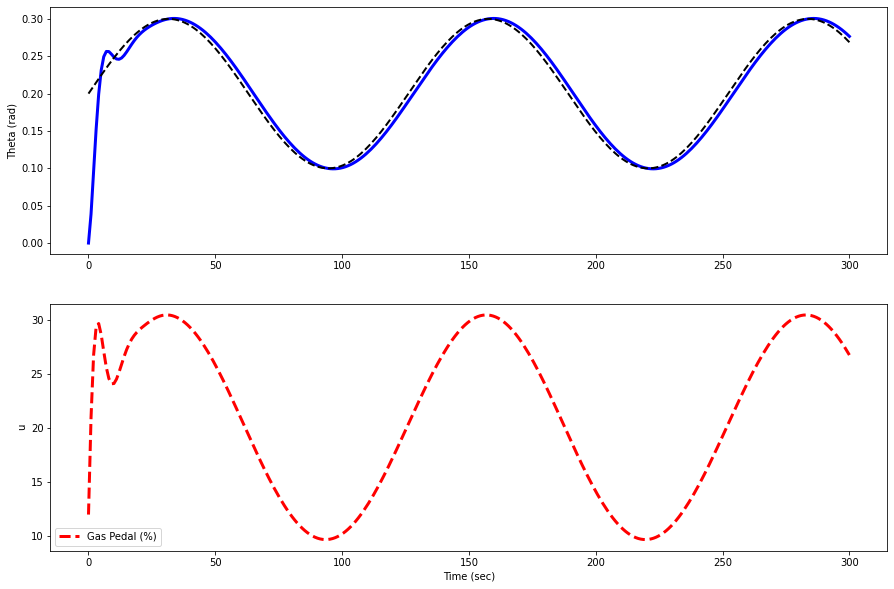

In [8]:
# plot results
plt.rcParams["figure.figsize"] = (15,10)
plt.subplot(2,1,1)
plt.plot(ts,theta_store,'b-',linewidth=3)
plt.plot(ts,sp_store,'k--',linewidth=2)
plt.ylabel('Theta (rad)')
#plt.legend(['Theta','Set Point'],loc=2)
plt.subplot(2,1,2)
plt.plot(ts,step,'r--',linewidth=3)
plt.ylabel('u')    
plt.legend(['Gas Pedal (%)'])
plt.xlabel('Time (sec)')
plt.show()

In [9]:
from moonlight import *

In [10]:
script = """
signal { real x; real y;}
domain boolean; 
formula anglelimit = eventually ((x == y) -> (globally(x < y)));
"""
moonlightScript = ScriptLoader.loadFromText(script)

[[  0.   1.]
 [300.   1.]]


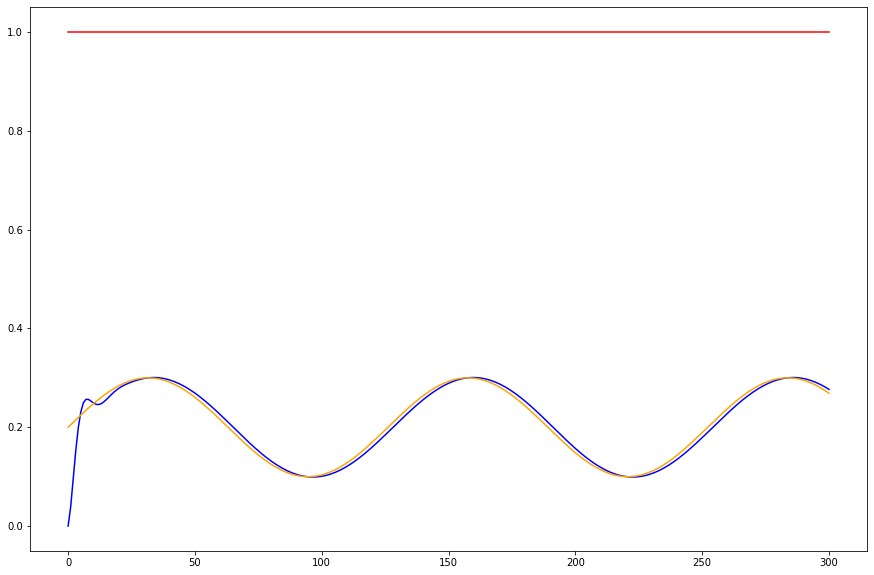

In [11]:
#theta_store
#sp_store

## STEP 4: getting the monitor associated with a target formula
futureMonitor = moonlightScript.getMonitor("anglelimit");

## STEP 5: monitor the signal
eps = 0.1
y = sp_store# + 0.1
ts_temp = list(ts) 
signals = list(zip(theta_store, y))
result = futureMonitor.monitor(ts_temp,signals)
arrayresults = np.array(futureMonitor.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,theta_store, color="blue")
plt.plot(ts_temp,y, color="orange")
plt.step(arrayresults[:,0],arrayresults[:,1], color="red")
print(arrayresults)

In [12]:
# Formula phi_1

script = """
signal { real x; }
domain boolean; 
formula speed_changes = globally (x < 5);
"""

moonlightScript = ScriptLoader.loadFromText(script)

[[  0.   1.]
 [300.   1.]]


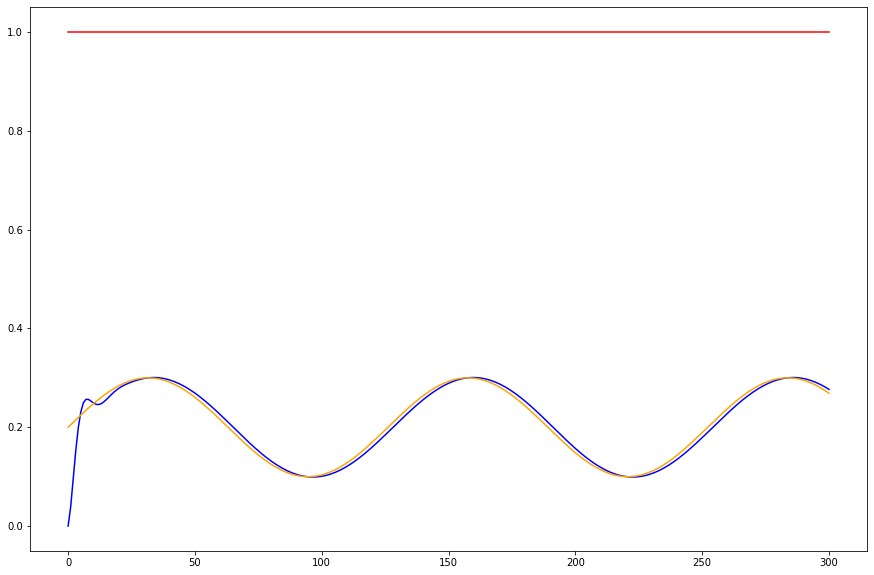

In [13]:
futureMonitor = moonlightScript.getMonitor("speed_changes");

# Monitor the signal
ts_temp = list(ts)
delta_v = np.zeros(300)
for i in range(1,len(delta_v)):
    delta_v[i] = v_store[i] - v_store[i-1]
signals = list(zip(delta_v))
result = futureMonitor.monitor(ts_temp,signals)
arrayresults = np.array(futureMonitor.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,theta_store, color="blue")
plt.plot(ts_temp,sp_store, color="orange")
#plt.plot(ts_temp,(step > 0), color="yellow")
plt.step(arrayresults[:,0],arrayresults[:,1], color="red")
print(arrayresults)

In [14]:
# Formula phi_2

script = """
signal { real x; real y; }
domain boolean; 
formula min_oscillation = eventually {globally ((x < 0.1) & (x > (-0.1)))};
"""

moonlightScript = ScriptLoader.loadFromText(script)

In [15]:
futureMonitor = moonlightScript.getMonitor("min_oscillation");

# Monitor the signal
ts_temp = list(ts)
x_vals = abs(theta_store - sp_store)
signals = list(zip(x_vals, y))
result = futureMonitor.monitor(ts_temp,signals)
arrayresults = np.array(futureMonitor.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,theta_store, color="blue")
plt.plot(ts_temp,sp_store, color="orange")
#plt.plot(ts_temp,(step > 0), color="yellow")
plt.step(arrayresults[:,0],arrayresults[:,1], color="red")
print(arrayresults)

JavaException: JVM exception occurred: java.lang.IllegalArgumentException

In [16]:
# Formula phi_3

script = """
signal { real x; real y; real u;}
domain boolean; 
formula positive_acceleration = globally ((x < y) -> (u > 0));
formula negative_acceleration = globally ((x > y) -> (u < 0));
"""

moonlightScript = ScriptLoader.loadFromText(script)

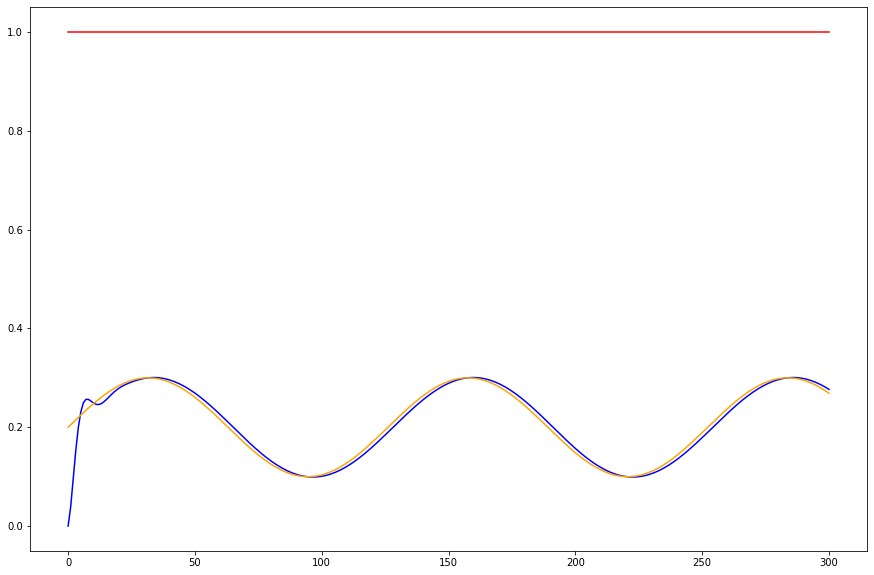

In [17]:
futureMonitor = moonlightScript.getMonitor("positive_acceleration");

# Monitor the signal
ts_temp = list(ts) 
signals = list(zip(theta_store, sp_store, step))
result = futureMonitor.monitor(ts_temp,signals)
arrayresults = np.array(futureMonitor.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,theta_store, color="blue")
plt.plot(ts_temp,sp_store, color="orange")
#plt.plot(ts_temp,(step > 0), color="yellow")
plt.step(arrayresults[:,0],arrayresults[:,1], color="red")

[[  0.  -1.]
 [300.  -1.]]


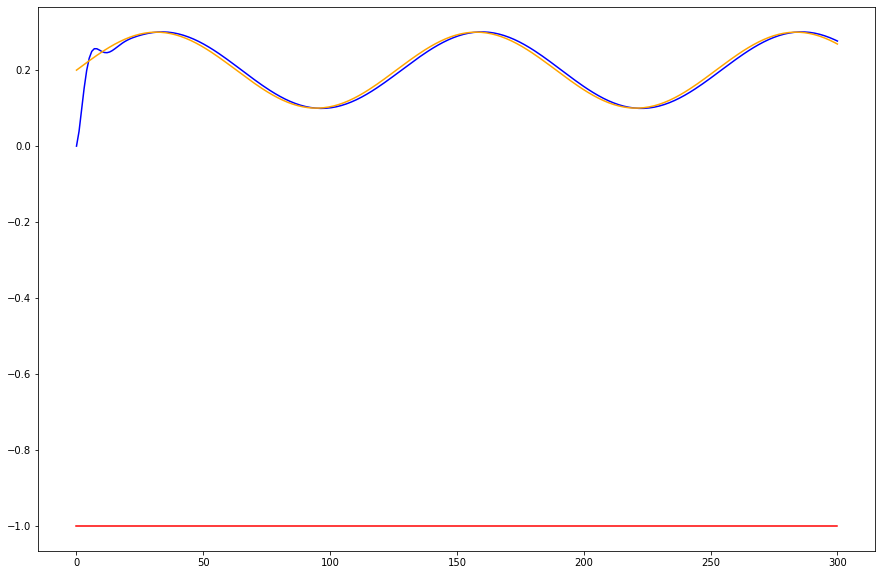

In [18]:
futureMonitor = moonlightScript.getMonitor("negative_acceleration");

# Monitor the signal
ts_temp = list(ts) 
signals = list(zip(theta_store, sp_store, step))
result = futureMonitor.monitor(ts_temp,signals)
arrayresults = np.array(futureMonitor.monitor(ts_temp,signals))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts_temp,theta_store, color="blue")
plt.plot(ts_temp,sp_store, color="orange")
#plt.plot(ts_temp,(step > 0), color="yellow")
plt.step(arrayresults[:,0],arrayresults[:,1], color="red")
print(arrayresults)

In [21]:
mi, sigma = 0.0,.1
n = np.random.normal(mi,sigma, 100)

# L'idea è che aggiungo questo rumore all'osservazione dei sensori e controllo la robustness con o senza rumore
# RICORDA: formula verificata -> robustness > 0 

array([ 6.18021541e-02,  4.97857819e-02, -1.38460911e-01,  1.45571080e-01,
       -3.15313307e-02, -2.16203298e-01, -5.73145182e-03,  7.80821585e-02,
        2.42678622e-02, -1.43495698e-01, -6.35039306e-02, -3.71257409e-02,
       -1.09022932e-01,  4.48541516e-02, -1.10205937e-01,  2.22863732e-02,
       -7.30483223e-02, -6.64920787e-02, -2.77139972e-01,  1.76734318e-02,
       -3.33384007e-05, -2.08496683e-02,  2.49815498e-02, -7.55134238e-02,
        1.68973568e-01,  7.54236142e-02,  7.24962321e-02, -1.41432890e-01,
       -5.82875089e-02,  1.64976991e-01,  1.31787298e-02,  1.20062703e-02,
       -8.23835195e-02,  7.23689920e-02,  1.71168513e-01,  6.84952588e-02,
        1.13405345e-01,  6.27870467e-02, -9.97707247e-03, -8.31147983e-03,
       -1.15874205e-01,  1.30803549e-01, -5.46020096e-02, -1.53170578e-01,
       -5.28438966e-02,  1.38697855e-01,  3.74308792e-02, -9.17437257e-02,
        1.28755843e-01, -1.29944726e-01, -1.39723170e-01, -1.57877843e-02,
        1.56828327e-04,  